In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import climo_utils as cu
import utils
import calc

import plot

In [3]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps y

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/33728/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/33728/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.62:35964,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/33728/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
def monthly_clim(ds):
    return ds.groupby('time.month').mean('time')

In [6]:
time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'MOC',
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'moc-{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time']
    ))
    
ds = xr.merge(ds_list)
#dsp = utils.pop_add_cyclic(ds)
#dsp.info()

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/moc-MOC.nc


In [7]:
client.close()
cluster.close()
del client
del cluster

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already 

In [8]:
ds.MOC

<xarray.DataArray 'MOC' (transport_reg: 2, moc_comp: 3, moc_z: 61, lat_aux_grid: 395)>
[144570 values with dtype=float32]
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    coordinates:   lat_aux_grid moc_z moc_components transport_region time
    cell_methods:  time: mean

In [9]:
MOC = ds.MOC.sum('moc_comp').assign_coords({'transport_reg': ['Global', 'Atlantic']})
moc_pac = (MOC.sel(transport_reg='Global') - MOC.sel(transport_reg='Atlantic')).expand_dims({'transport_reg': ['Pacific']})
MOC = xr.concat((MOC, moc_pac), dim='transport_reg')
MOC

<xarray.DataArray 'MOC' (transport_reg: 3, moc_z: 61, lat_aux_grid: 395)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.85520867e-06,  5.24118377e-07, -2.35349695e-09],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.18122970e-02, -3.79744172e-02, -3.66504043e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.56482786e-01, -1.50337666e-01, -1.48353726e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.39341142e-07, -3.39341142e-07, -3.39341142e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.57798453e-07, -1.57798453e-07, -1.57798453e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.07087588e+00,  1.07087588e+00,  1.07087588e+00, ...,
          1.07104623e+00,  1.07104492e+00,  1.07104445e+00],
        [ 4.43066776e-01,  4.43066776e-01,  4.43066776e-01, ...,
          7.10649490e-01,  7.14487374e-01,  7.15811312e-01],
        [ 2.64365315e-01,  2.64365315e-01,  2.64365315e-01, ...,
          2.83873856e-01,  2.90018976e-01,  2.92002916e-01],
...
         -1.37023406e-07, -1.37023406e-07, -1.37023406e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.27740731e-08, -5.27740731e-08, -5.27740731e-08],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.07087588e+00, -1.07087588e+00, -1.07087588e+00, ...,
         -1.07104433e+00, -1.07104445e+00, -1.07104445e+00],
        [-4.43066776e-01, -4.43066776e-01, -4.43066776e-01, ...,
         -7.52461791e-01, -7.52461791e-01, -7.52461731e-01],
        [-2.64365315e-01, -2.64365315e-01, -2.64365315e-01, ...,
         -4.40356642e-01, -4.40356642e-01, -4.40356642e-01],
        ...,
        [ 1.66422091e-02,  1.66422091e-02,  1.66422091e-02, ...,
         -2.02317736e-07, -2.02317736e-07, -2.02317736e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.05024384e-07, -1.05024384e-07, -1.05024384e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      dtype=float32)
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z          (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
  * transport_reg  (transport_reg) <U8 'Global' 'Atlantic' 'Pacific'

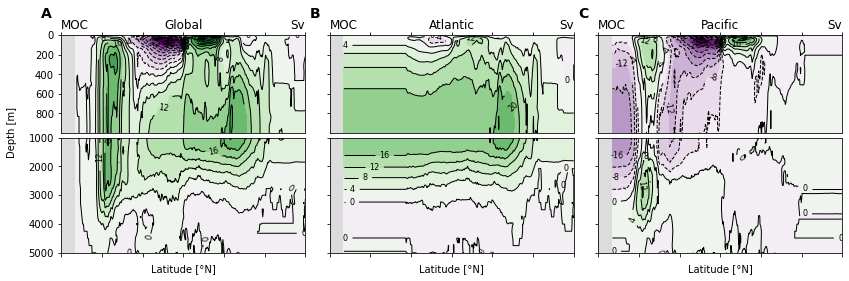

In [10]:
plot.moc(MOC)
utils.savefig('moc')